In [7]:
import matplotlib.pyplot as plt  # Library for plotting and visualizing data
import numpy as np  # Fundamental package for numerical computations and handling arrays
import os  # Module for interacting with the operating system
import tensorflow as tf  # TensorFlow, a comprehensive open-source platform for machine learning
import tensorflow.keras.layers as tfl  # Keras API for building and training neural networks
from tensorflow.keras.layers import Layer

# Functions for loading and augmenting image datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Load images from a directory and create a dataset
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast  # Layers for random image augmentations
from tensorflow.keras.regularizers import l2  # Apply L2 regularization to layers

# PIL (Python Imaging Library) for image processing
from PIL import ImageEnhance  # Module to enhance images (adjust brightness, contrast, sharpness, color)
from PIL import Image  # Module for opening, manipulating, and saving image files
import cv2
import seaborn as sns

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = r"C:\Users\YEP!\Downloads\AI-project/images/images"

# Install OpenCV if not already installed
# !pip install opencv-python

import os
import matplotlib.pyplot as plt
import numpy as np
# Helper function to load images
def load_images(directory, max_images=None):
    image_paths = []
    class_names = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(root, file))
                class_names.append(os.path.basename(root))
                if max_images and len(image_paths) >= max_images:
                    break
    return image_paths, class_names

# Load images
image_paths, class_names = load_images(directory, max_images=1000)  # Adjust max_images as needed
unique_classes = list(set(class_names))

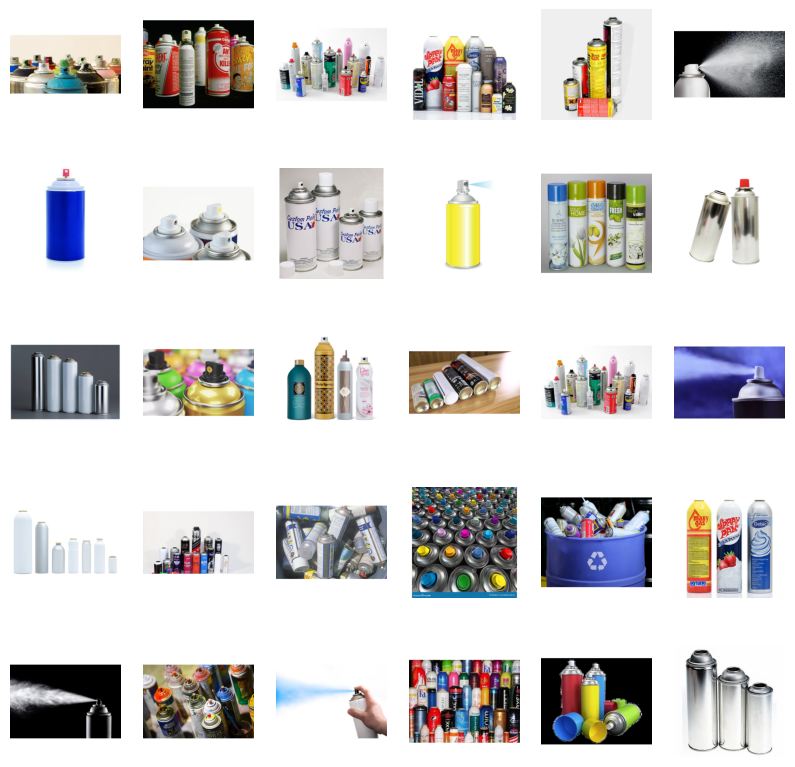

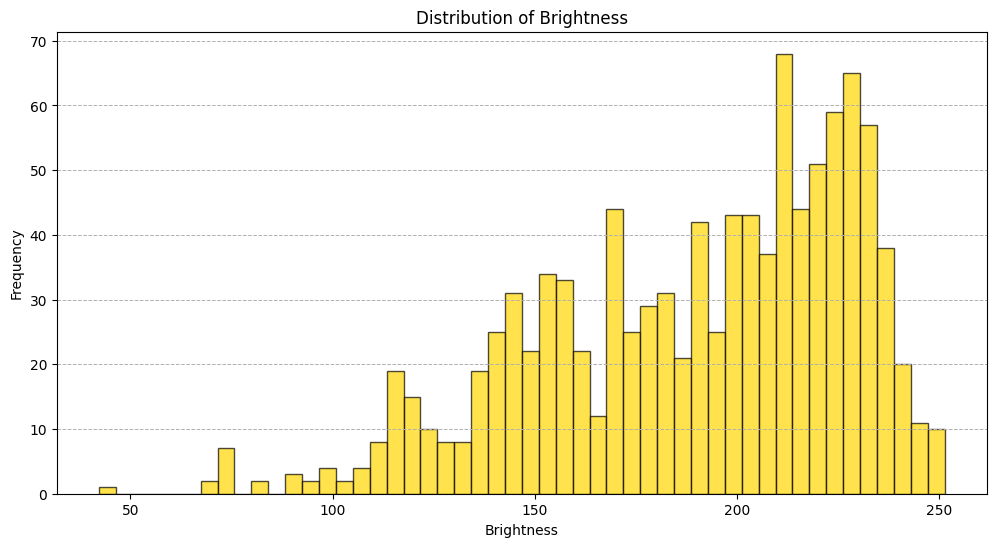

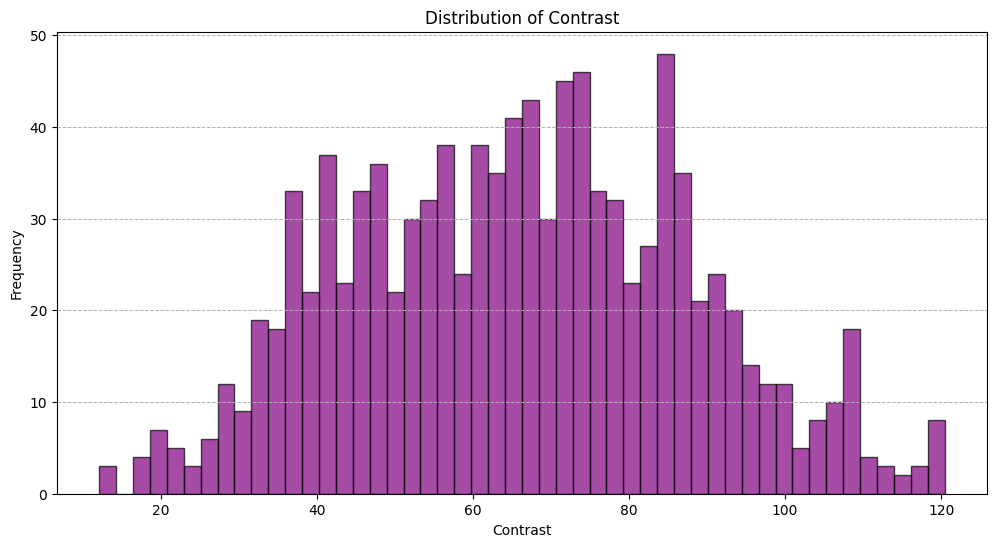

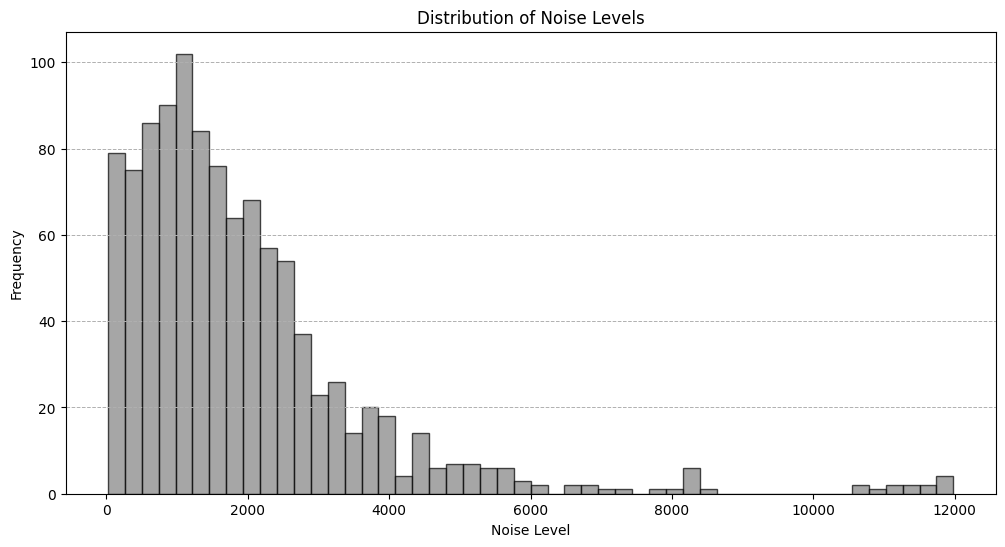

In [9]:
# EDA: Visualize a few images from the dataset
def show_images(image_paths, num_images=30):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        img = Image.open(image_paths[i])
        ax = plt.subplot(5, 6, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

show_images(image_paths)

# EDA: Analyze brightness and contrast distributions
def analyze_brightness_contrast(image_paths):
    brightness = []
    contrast = []
    for path in image_paths:
        img = Image.open(path).convert('L')  # Convert image to grayscale
        img = np.array(img)
        brightness.append(np.mean(img))
        contrast.append(np.std(img))
    return brightness, contrast

brightness, contrast = analyze_brightness_contrast(image_paths)

# Plot brightness and contrast distributions
plt.figure(figsize=(12, 6))
plt.hist(brightness, bins=50, alpha=0.7, label='Brightness', color='gold', edgecolor='black')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Distribution of Brightness')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(contrast, bins=50, alpha=0.7, label='Contrast', color='purple', edgecolor='black')
plt.xlabel('Contrast')
plt.ylabel('Frequency')
plt.title('Distribution of Contrast')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

# EDA: Analyze color distribution
def analyze_color_distribution(image_paths):
    color_means = []
    color_stds = []
    for path in image_paths:
        img = Image.open(path)
        img = np.array(img)
        color_means.append(np.mean(img, axis=(0, 1)))
        color_stds.append(np.std(img, axis=(0, 1)))
    return color_means, color_stds

color_means, color_stds = analyze_color_distribution(image_paths)
color_means = np.array(color_means)
color_stds = np.array(color_stds)

# EDA: Identify and visualize noisy images
def analyze_noise(image_paths):
    noise_levels = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        noise = cv2.Laplacian(img, cv2.CV_64F).var()
        noise_levels.append(noise)
    return noise_levels

noise_levels = analyze_noise(image_paths)

# Plot noise levels distribution
plt.figure(figsize=(12, 6))
plt.hist(noise_levels, bins=50, alpha=0.7, label='Noise Level', color='grey', edgecolor='black')
plt.xlabel('Noise Level')
plt.ylabel('Frequency')
plt.title('Distribution of Noise Levels')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

C:\Users\YEP!\AppData\Local\Temp\ipykernel_13212\2617709058.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(saturation, shade=True, color='cyan', label='Saturation')


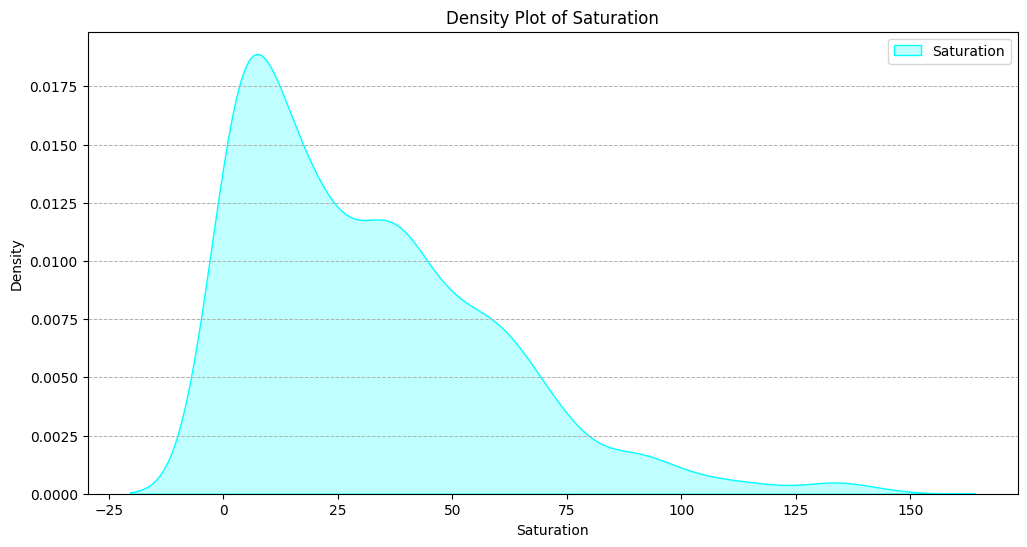

C:\Users\YEP!\AppData\Local\Temp\ipykernel_13212\2617709058.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hue, shade=True, color='orange', label='Hue')


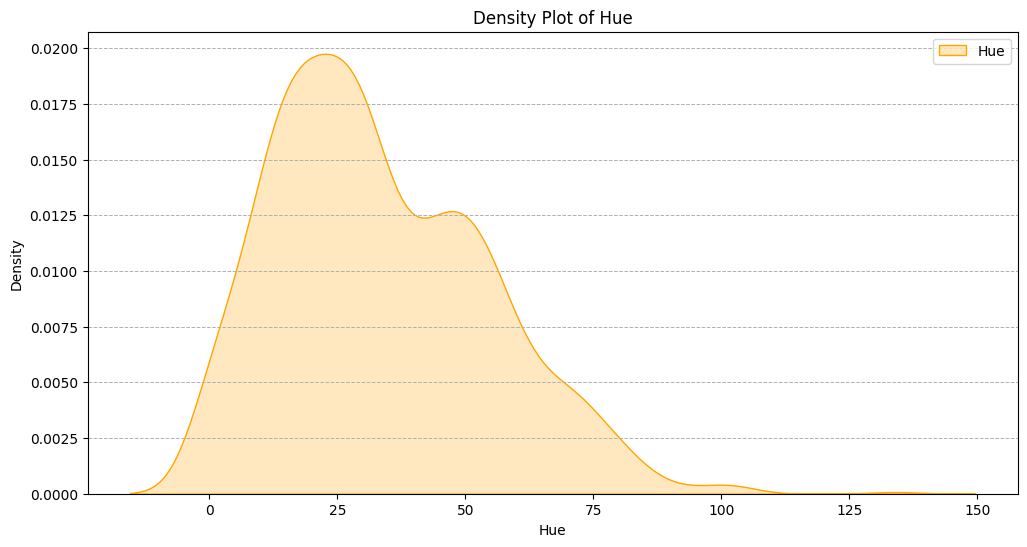

In [10]:
# EDA: Analyze saturation and hue distributions
def analyze_saturation_hue(image_paths):
    saturation = []
    hue = []
    for path in image_paths:
        img = cv2.imread(path)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hue.append(np.mean(img_hsv[:, :, 0]))
        saturation.append(np.mean(img_hsv[:, :, 1]))
    return saturation, hue

saturation, hue = analyze_saturation_hue(image_paths)

# Plot density plots for saturation and hue
plt.figure(figsize=(12, 6))
sns.kdeplot(saturation, shade=True, color='cyan', label='Saturation')
plt.xlabel('Saturation')
plt.ylabel('Density')
plt.title('Density Plot of Saturation')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(hue, shade=True, color='orange', label='Hue')
plt.xlabel('Hue')
plt.ylabel('Density')
plt.title('Density Plot of Hue')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

In [11]:
# Define the training dataset
train_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,  # Shuffle the dataset to ensure random distribution
    batch_size=BATCH_SIZE,  # Number of images to process in a single batch
    image_size=IMG_SIZE,  # Resize all images to 224x224 pixels
    validation_split=0.2,  # Reserve 20% of the data for validation
    subset='training',  # This dataset is for training
    seed=42  # Random seed for reproducibility
)

# Define the validation dataset
validation_dataset = image_dataset_from_directory(
    directory,
    labels='inferred',  # Automatically infers labels from subdirectory names
    label_mode='categorical',  # Return labels as one-hot encoded vectors
    shuffle=True,  # Shuffle the dataset to ensure random distribution
    batch_size=BATCH_SIZE,  # Number of images to process in a single batch
    image_size=IMG_SIZE,  # Resize all images to 224x224 pixels
    validation_split=0.2,  # Reserve 20% of the data for validation
    subset='validation',  # This dataset is for validation
    seed=42  # Random seed for reproducibility
)

Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Found 15000 files belonging to 30 classes.
Using 3000 files for validation.


In [12]:
# Verify the dataset structure
class_names = train_dataset.class_names  # Retrieve the class names inferred from the subdirectory names

# Print each waste class name on a new line
num_classes = len(class_names)
print(f"Number of waste classes: {num_classes}")
print("Waste class names:")
for class_name in class_names:
    print(class_name)

Number of waste classes: 30
Waste class names:
aerosol_cans
aluminum_food_cans
aluminum_soda_cans
cardboard_boxes
cardboard_packaging
clothing
coffee_grounds
disposable_plastic_cutlery
eggshells
food_waste
glass_beverage_bottles
glass_cosmetic_containers
glass_food_jars
magazines
newspaper
office_paper
paper_cups
plastic_cup_lids
plastic_detergent_bottles
plastic_food_containers
plastic_shopping_bags
plastic_soda_bottles
plastic_straws
plastic_trash_bags
plastic_water_bottles
shoes
steel_food_cans
styrofoam_cups
styrofoam_food_containers
tea_bags


Exploring the image quality -- checking the low, high and average image quality

Visualizing the class distribution in both traning and validation dataset.

Image Augmentation -- Image augmentation is performed to enhance the training dataset for machine learning models, particularly in the context of computer vision tasks such as image classification, object detection, and segmentation.

RandomFlip -- Helps the model learn invariant features, improving its ability to recognize objects regardless of their orientation.

RandomRotation -- Enhances the model's robustness to rotation variations, making it more effective at recognizing objects in different orientations.

RandomZoom -- Helps the model handle scale variations, which is important for detecting objects of varying sizes in the input images.

RandomContrast -- Improves the model's ability to handle different lighting conditions and contrasts, making it more robust to changes in illumination.

RandomBrightness -- Enhances the model's robustness to lighting variations, ensuring it can accurately recognize objects in different lighting conditions.

RandomSharpness -- Sharpness adjustments can help the model learn to detect edges and fine details more effectively, which is crucial for tasks requiring high precision, such as medical imaging.

RandomNoise -- Noise addition helps the model become more robust to imperfections and noise in real-world data, which can improve generalization.

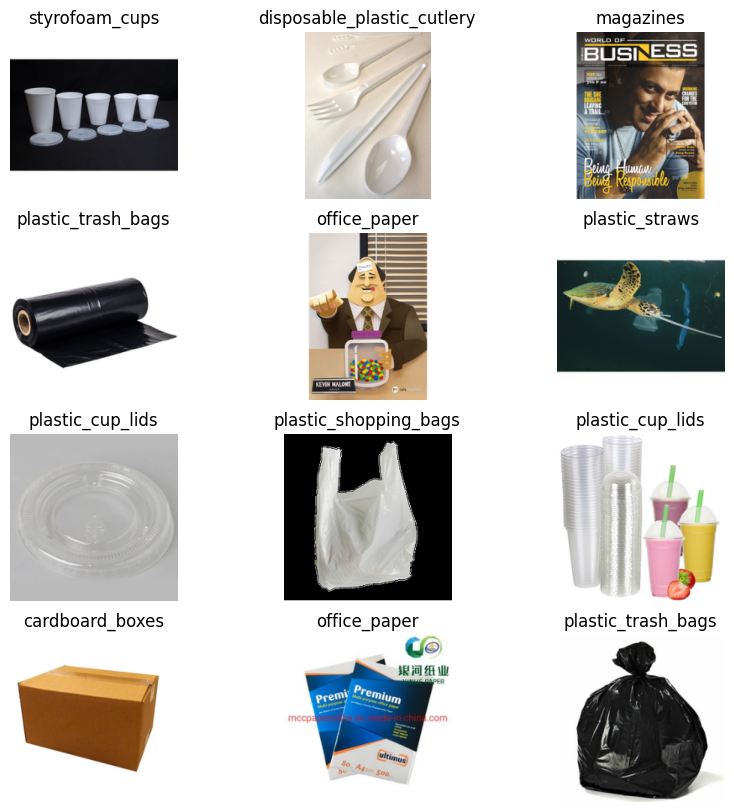

In [13]:
plt.figure(figsize=(10, 10))  # Set the figure size for the plot

# Iterate over the first 2 batches from the training dataset
for images, labels in train_dataset.take(2):
    # Plot 12 images from the current batch
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)  # Create a subplot in a 4x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image
        label_index = tf.argmax(labels[i]).numpy()  # Get the index of the highest value (class)
        plt.title(class_names[label_index])  # Set the title to the class name
        plt.axis("off")  # Hide the axis

plt.show()  # Display the plot

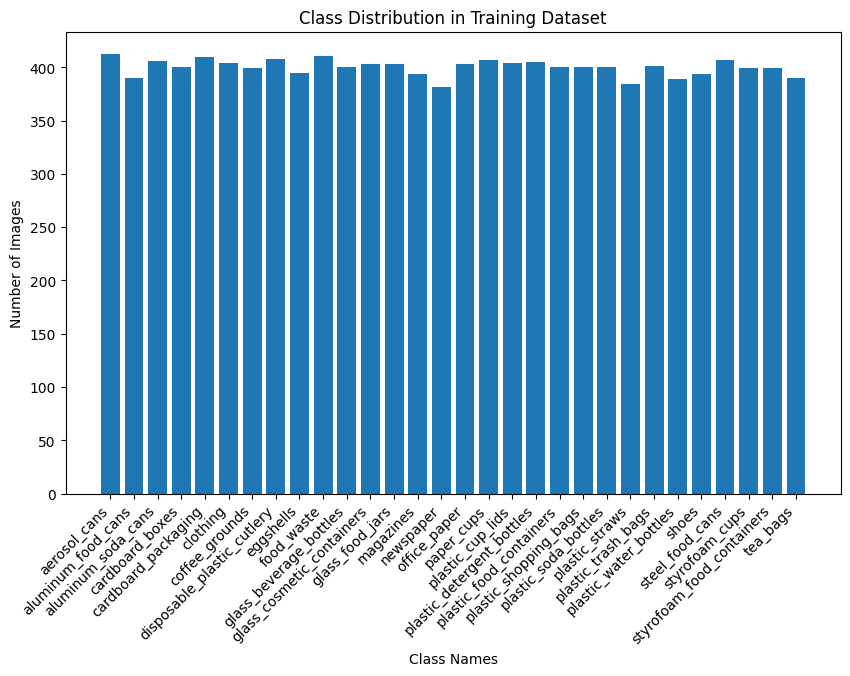

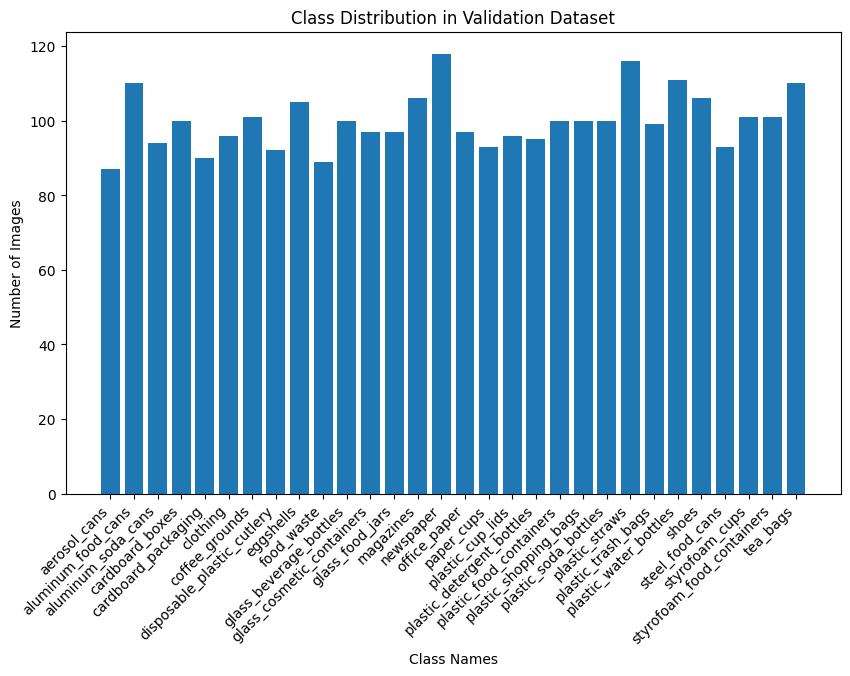

In [14]:
# Check class distribution in the training dataset
class_counts = {class_name: 0 for class_name in class_names}  # Initialize a dictionary to store counts for each class
for _, labels in train_dataset:  # Iterate through batches in the training dataset
    for label in labels:  # Iterate through labels in each batch
        class_index = tf.argmax(label).numpy()  # Get the index of the highest value (class)
        class_name = class_names[class_index]  # Get the class name corresponding to the index
        class_counts[class_name] += 1  # Increment the count for the class

# Plot class distribution for the training dataset
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.bar(class_counts.keys(), class_counts.values())  # Create a bar plot of class counts
plt.xlabel('Class Names')  # Set the label for the x-axis
plt.ylabel('Number of Images')  # Set the label for the y-axis
plt.title('Class Distribution in Training Dataset')  # Set the title of the plot
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.show()  # Display the plot

# Check class distribution in the validation dataset
class_counts = {class_name: 0 for class_name in class_names}  # Reinitialize the dictionary for validation dataset
for _, labels in validation_dataset:  # Iterate through batches in the validation dataset
    for label in labels:  # Iterate through labels in each batch
        class_index = tf.argmax(label).numpy()  # Get the index of the highest value (class)
        class_name = class_names[class_index]  # Get the class name corresponding to the index
        class_counts[class_name] += 1  # Increment the count for the class

# Plot class distribution for the validation dataset
plt.figure(figsize=(10, 6))  # Set the figure size for the plot
plt.bar(class_counts.keys(), class_counts.values())  # Create a bar plot of class counts
plt.xlabel('Class Names')  # Set the label for the x-axis
plt.ylabel('Number of Images')  # Set the label for the y-axis
plt.title('Class Distribution in Validation Dataset')  # Set the title of the plot
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
plt.show()  # Display the plot

In [15]:
    # Function to assess image quality for a single image
    def assess_image_quality(image):
        # Convert PIL Image to numpy array and then to TensorFlow tensor
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.expand_dims(image, axis=0)  # Add batch dimension

        # Ensure image is in RGB format if required
        if image.shape[-1] != 3:
            image = tf.image.grayscale_to_rgb(image)

        # Apply Sobel edges operation
        edge_image = tf.image.sobel_edges(image)

        # Calculate edge magnitude
        edge_magnitude = tf.sqrt(tf.reduce_sum(tf.square(edge_image), axis=-1))

        # Calculate quality score as the mean edge magnitude
        quality_score = tf.reduce_mean(edge_magnitude).numpy()

        return quality_score

    # Function to analyze image quality for a dataset
    def image_quality_analysis(dataset):
        quality_scores = []
        for image_batch, _ in dataset:  # Iterate directly over the dataset
            for image in image_batch:
                quality_score = assess_image_quality(image)
                quality_scores.append(quality_score)
        return quality_scores

    # Example usage for a single image
    image_path = r"C:\Users\YEP!\Downloads\AI-project/images/images/aluminum_soda_cans/real_world/Image_194.png"
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))  # Load and resize image
    quality_score = assess_image_quality(image)  # Assess quality of a single image
    print(f"Single Image Quality Score: {quality_score}")

    # Example usage of image_quality_analysis function on a dataset
    quality_scores = image_quality_analysis(train_dataset)  # Assess quality of images in the training dataset
    print(f"Image Quality Scores: {quality_scores}")


Single Image Quality Score: 87.8055419921875
Image Quality Scores: [70.827, 64.59685, 42.513927, 42.159554, 109.11168, 40.533035, 74.190605, 60.230072, 50.91577, 48.800938, 98.31922, 68.590935, 60.982594, 113.7416, 115.08015, 138.90417, 75.00156, 49.792854, 57.93826, 67.71219, 71.958534, 24.583225, 72.84674, 93.553825, 56.497616, 99.00532, 65.4525, 97.48596, 13.601059, 57.323044, 65.827225, 19.451706, 64.75214, 39.752796, 40.30515, 52.511395, 23.409113, 58.49907, 70.521614, 185.27368, 50.473278, 13.070375, 60.821003, 88.192055, 51.8904, 140.91284, 47.260822, 150.06891, 40.141838, 35.135174, 61.603962, 21.747822, 39.437813, 18.567467, 35.667007, 85.213745, 78.35001, 30.501564, 17.903606, 18.084684, 74.02911, 60.87627, 29.082283, 69.63868, 48.34005, 57.7276, 55.757587, 43.183296, 55.66908, 82.31432, 88.07236, 41.470703, 84.3721, 13.349217, 43.52547, 42.419315, 64.55086, 95.54345, 117.86403, 122.32548, 84.7504, 49.527378, 36.24872, 13.034234, 44.97617, 52.836285, 113.02578, 64.66389, 37.5

In [16]:
# Calculate average image quality score
average_quality = np.mean(quality_scores)

# Calculate mean quality score
mean_quality = np.median(quality_scores)

# Calculate low quality score (minimum)
low_quality = np.min(quality_scores)

# Calculate high quality score (maximum)
high_quality = np.max(quality_scores)

print(f"Average Image Quality Score: {average_quality}")
print(f"Mean Quality Score: {mean_quality}")
print(f"Low Quality Score: {low_quality}")
print(f"High Quality Score: {high_quality}")


Average Image Quality Score: 58.97566604614258
Mean Quality Score: 53.7671012878418
Low Quality Score: 2.5435562133789062
High Quality Score: 242.90975952148438


# Data Augmentation

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [18]:
class RandomNoise(Layer):
    def __init__(self, mean=0.0, stddev=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mean = mean
        self.stddev = stddev

    def call(self, inputs, training=True):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=self.mean, stddev=self.stddev)
            return inputs + noise
        return inputs

class RandomBrightness(Layer):
    def __init__(self, max_delta=0.2, **kwargs):
        super().__init__(**kwargs)
        self.max_delta = max_delta

    def call(self, inputs, training=True):
        if training:
            return tf.image.random_brightness(inputs, max_delta=self.max_delta)
        return inputs

class RandomSharpness(Layer):
    def __init__(self, alpha=1.5, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def call(self, inputs, training=True):
        if training:
            # Apply contrast as a proxy for sharpness adjustment
            inputs = tf.image.random_contrast(inputs, lower=0.5, upper=1.5)
        return inputs

class RandomColorJitter(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs, training=True):
        if training:
            inputs = tf.image.random_hue(inputs, 0.1)  # Adjusted hue range based on histogram Adjust the hue to reflect a range around the mode of the distribution, approximately ±0.1
            inputs = tf.image.random_saturation(inputs, 0.2, 1.2)  # Adjusted saturation range based on histogram Adjust the saturation range to reflect the distribution in the histogram, around 0.2 to 1.2.The saturation histogram shows a right-skewed distribution with most values concentrated between 0 and 60
            inputs = tf.image.random_brightness(inputs, 0.05)
            inputs = tf.image.random_contrast(inputs, 0.7, 1.3)
        return inputs

class RandomContrast(Layer):
    def __init__(self, contrast_factor=0.2, **kwargs):
        super().__init__(**kwargs)
        self.contrast_factor = contrast_factor

    def call(self, inputs, training=True):
        if training:
            return tf.image.random_contrast(inputs, 1 - self.contrast_factor, 1 + self.contrast_factor)
        return inputs

def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
    data_augmentation.add(tf.keras.layers.RandomRotation(0.2))
    data_augmentation.add(tf.keras.layers.RandomZoom(0.2))
    data_augmentation.add(RandomContrast(0.2)) # The contrast histogram ranges from 0 to 120, with a significant concentration between 20 and 100. A contrast factor of 0.3 allows the contrast to vary by ±30%. This ensures that the contrast adjustments will not be too extreme, maintaining the visual quality of the images while introducing enough variability to enhance model robustness. For example, an image with a contrast value of 80 can be adjusted to range between 56 (70% of 80) and 104 (130% of 80).
    data_augmentation.add(RandomBrightness(0.2))#The brightness histogram shows a wide range from 0 to 250, with most values between 100 and 250.A factor of 0.3 allows the brightness to vary by ±30% of its original value. This means that an image with a mean brightness value of 200 could be augmented to have a brightness between 140 (70% of 200) and 260 (130% of 200). This range covers most of the natural variability seen in the dataset without making the images too dark or too bright.
    data_augmentation.add(RandomSharpness(alpha=1.5))  # Adjust sharpness using contrast
    data_augmentation.add(RandomNoise(mean=0.0, stddev=20.0)) # Given the central tendency around 1000-2000, we use a scaling factor to set stddev to 0.01 * 2000 = 20. We keep mean at 0.0 since the noise is centered around 0. This ensures that the noise added during augmentation is representative of the dataset.
    
    return data_augmentation


In [19]:
# Create the data augmentation model
data_augmentation = data_augmenter()

# # Visualize the augmented images
# for image, _ in train_dataset.take(4):  # Take the first 3 batches from the training dataset
#     plt.figure(figsize=(10, 10))  # Set the figure size
#     first_image = image[0]  # Get the first image from the batch
#     for i in range(12):  # Generate 12 augmented images
#         ax = plt.subplot(5, 3, i + 1)  # Create a subplot in a 5x3 grid
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))  # Apply augmentation
#         plt.imshow(augmented_image[0] / 255)  # Display the augmented image
#         plt.axis('off')  # Hide the axis
#     plt.show()  # Display the plot

# Define a function to apply augmentation to the dataset
def augment(image, label):
    image = data_augmentation(image)  # Apply data augmentation to the image
    return image, label  # Return the augmented image and the label

# Apply the augmentation function to the training dataset
augmented_train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# MODEL : EfficientNet B0

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models

# Step 1: Load the EfficientNet-B0 model with pre-trained weights
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Step 2: Freeze the base model layers to retain pre-trained features
base_model.trainable = False

# Step 3: Add custom layers on top of the base model
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),  # Preprocess input
    base_model,
    layers.GlobalAveragePooling2D(),  # Add a global average pooling layer
    layers.Dropout(0.2),  # Add a dropout layer for regularization
    layers.Dense(30, activation='softmax')  # Add a dense layer with softmax activation for classification
])

# Step 4: Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Use Adam optimizer
    loss='categorical_crossentropy',  # Use categorical crossentropy loss
    metrics=['accuracy']  # Track accuracy metric
)

# Print the model summary to verify the architecture
model.summary()

# Step 5: Train the model
history = model.fit(
    augmented_train_dataset,
    validation_data=validation_dataset,
    epochs=50  # Number of epochs, adjust based on your needs
)




16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


c:\Users\YEP!\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        38,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,001 (15.59 MB)

 Trainable params: 38,430 (150.12 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.3335 - loss: 2.4690 - val_accuracy: 0.6563 - val_loss: 1.2455
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 376s 998ms/step - accuracy: 0.5681 - loss: 1.5067 - val_accuracy: 0.6810 - val_loss: 1.0932
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.5945 - loss: 1.3660 - val_accuracy: 0.6987 - val_loss: 1.0008
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.6344 - loss: 1.2451 - val_accuracy: 0.7083 - val_loss: 0.9746
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.6464 - loss: 1.2057 - val_accuracy: 0.7160 - val_loss: 0.9464
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.6359 - loss: 1.2046 - val_accuracy: 0.7150 - val_loss: 0.9332
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.6597 - loss: 1.1454 - val_accuracy: 0.7173 - val_loss: 0.9198
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 363s 964ms/step - accuracy: 0.6657 - loss: 1.1162 - va

ValueError: not enough values to unpack (expected 4, got 2)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

# Step 1: Load the EfficientNet-B0 model with pre-trained weights
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Step 2: Unfreeze the top layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Step 3: Add custom layers on top of the base model
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    layers.Lambda(preprocess_input),  # Preprocess input
    base_model,
    layers.GlobalAveragePooling2D(),  # Add a global average pooling layer
    layers.Dropout(0.5),  # Increase dropout for regularization
    layers.Dense(256, activation='relu'),  # Add a dense layer with ReLU activation
    layers.Dropout(0.5),  # Add another dropout layer for regularization
    layers.Dense(len(class_names), activation='softmax')  # Add a dense layer with softmax activation for classification
])

# Step 4: Compile the model with a lower learning rate and learning rate scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',  AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Step 5: Train the model
history = model.fit(
    augmented_train_dataset,
    validation_data=validation_dataset,
    epochs=20,  # Increase the number of epochs
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.0891 - auc: 0.6035 - loss: 3.3527 - precision: 0.4594 - recall: 0.0022 - val_accuracy: 0.4370 - val_auc: 0.9147 - val_loss: 2.2372 - val_precision: 0.8841 - val_recall: 0.1093 - learning_rate: 1.0000e-04
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.3480 - auc: 0.8625 - loss: 2.3617 - precision: 0.8330 - recall: 0.1226 - val_accuracy: 0.5930 - val_auc: 0.9630 - val_loss: 1.4735 - val_precision: 0.8089 - val_recall: 0.3103 - learning_rate: 1.0000e-04
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 423s 1s/step - accuracy: 0.4477 - auc: 0.9140 - loss: 1.9256 - precision: 0.7614 - recall: 0.2410 - val_accuracy: 0.6440 - val_auc: 0.9716 - val_loss: 1.2297 - val_precision: 0.8134 - val_recall: 0.4127 - learning_rate: 1.0000e-04
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.5173 - auc: 0.9346 - loss: 1.6829 - precision: 0.7695 - recall: 0.3240 - val_accuracy: 0.6887 - val_auc: 0.9775 - val_lo

In [26]:
# Step 6: Evaluate the model on the validation dataset
eval_results = model.evaluate(validation_dataset)

# Print evaluation results
print("Validation Loss: {:.4f}".format(eval_results[0]))
print("Validation Accuracy: {:.4f}".format(eval_results[1]))
print("Validation AUC: {:.4f}".format(eval_results[2]))
print("Validation Precision: {:.4f}".format(eval_results[3]))
print("Validation Recall: {:.4f}".format(eval_results[4]))


94/94 ━━━━━━━━━━━━━━━━━━━━ 81s 859ms/step - accuracy: 0.7386 - auc: 0.9804 - loss: 0.8057 - precision: 0.8037 - recall: 0.6797
Validation Loss: 0.7940
Validation Accuracy: 0.7403
Validation AUC: 0.9811
Validation Precision: 0.8050
Validation Recall: 0.6893


###SAVING THE MODEL FOR DEPLOYMENT

In [34]:
from tensorflow.keras.models import save_model

"""# Assuming 'model' is your EfficientNetB0-based model
model.save('efficientnetb0_model.h5')"""


In [36]:
"""# Save the model architecture
with open('efficientnetb0_model_architecture.json', 'w') as f:
    f.write(model.to_json())

# Save the model weights with the correct filename
model.save_weights('efficientnetb0_model.weights.h5')"""


In [28]:
# Save the model in the recommended Keras format
model.save('C:/Users/Yep!/Downloads/AImodel.keras')  


## UI FOR IMAGE CLASSIFICATOIN AND CHECK WETHER THE IMAGE IS RECYCLABLE OR NOT.

In [37]:
import gradio as gr
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define the waste classes and labels for the RandomForestClassifier
waste_classes = [
    'aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging',
    'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste',
    'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper',
    'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers',
    'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles',
    'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags'
]

labels = [
    0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
    1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
    1, 0, 0, 1, 0, 1, 0, 0, 0, 0
]

# Create a DataFrame
data = pd.DataFrame({'waste_class': waste_classes, 'label': labels})

# Convert text data into feature vectors
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['waste_class'])
y = data['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


class_names = waste_classes  

def preprocess_input(image):
   
    return image

# Define the combined function for Gradio
def classify_waste_image(image):
    # Image Classification
    image = tf.image.resize(image, (224, 224))
    image = tf.expand_dims(image, axis=0)
    image = preprocess_input(image)
    predictions = model.predict(image)
    top_class_index = np.argmax(predictions[0])
    waste_class = class_names[top_class_index]
    
    # Waste Classification
    waste_class_vector = vectorizer.transform([waste_class])
    recyclable = clf.predict(waste_class_vector)[0]
    result = 'Recyclable' if recyclable == 1 else 'Non-Recyclable'
    
    return f'{waste_class}: {result}'

# Creating Gradio interface
gr_interface = gr.Interface(
    fn=classify_waste_image,
    inputs=gr.Image(),
    outputs=gr.Textbox(label="Classification Results"),
    title="Waste Classification and Recyclability Checker",
    description="Upload an image to classify the waste and determine if it is recyclable."
)

if __name__ == "__main__":
    gr_interface.launch()


Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
